# Multi-Layer Perceptron

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from nn.structures import LayersSequence
from nn.linear import LinearLayer
from nn.losses import MeansSquareLoss, CrossEntropyLoss
from nn.activations import SigmoidActivation, ReLUActivation, SoftmaxActivation
from nn.visualizations import visualize_weights, visualize_activations

AttributeError: `np.float_` was removed in the NumPy 2.0 release. Use `np.float64` instead.

In [2]:
%matplotlib inline

### Linear regression y = f(x) - single perceptron

Sample data - a straight line with added noise.

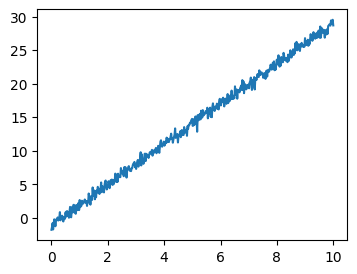

In [3]:
n_samples = 500
x = np.linspace(0, 10, n_samples)
y = 3 * x - 1 + np.random.normal(0, 0.5, size=n_samples)

fig, ax = plt.subplots(figsize=(4,3))
ax.plot(x,y)

We'll build a linear perceptron and try to learn the relationship between _y_ and _x_. This model final form is equivalent to linear regression. We'll repeat building the model 3 times - each time we start from different start values of parameters.

In [4]:
# Set number of epochs and learning rate
n_epochs = 50
lr = 0.01

models = []

for _ in range(3):
    
    # Create a linear perceptron instance and loss function instance
    linear_perceptron = LinearLayer(n_inputs=1, n_outputs=1)
    loss_fun = MeansSquareLoss()
    
    # The model takes data in 2D form
    X = x.reshape(-1, 1)
    Y_true = y.reshape(-1, 1)
    
    # Update perceptron with gradient descent n_epochs times
    for epoch in range(n_epochs):
        # forward step
        Y_pred = linear_perceptron.forward(X)
        # calculate loss derivative at each input
        loss_derivative = loss_fun.differentiate(Y_pred=Y_pred, Y_true=Y_true)
        # backward step (gradient is saved in perceptron object)
        linear_perceptron.backward(loss_derivative)
        # update step (gradient descent)
        linear_perceptron.update(lr=lr)

    # Add model to list
    models.append(linear_perceptron)

In [5]:
models

We'll see how well perceptron has learnt the relationship each time.

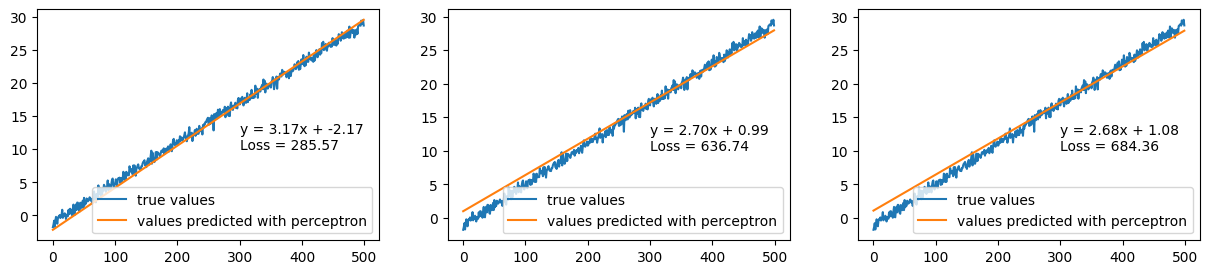

In [6]:
fig, axes = plt.subplots(1, 3, figsize=(15, 3))

for model, ax in zip(models, axes):
    # predict values of y with the model
    y_pred = model.forward(X)
    # calculate loss
    loss = loss_fun(Y_pred=y_pred, Y_true=y.reshape((-1, 1)))
    
    ax.plot(y, label='true values')
    ax.plot(y_pred, label='values predicted with perceptron')
    a = model.params_["weights"][0][0]
    b = model.params_["biases"][0]
    ax.text(300, 10, f"y = {a:.2f}x + {b:.2f}\nLoss = {loss:.2f}")
    
    ax.legend()

We can observe how gradient descent is sensitive to the start point and local minima.

### Logistic regression p(y = 1 | x) - perceptron with sigmoid activation

Sample data - samples from two 2-D normal distributions.

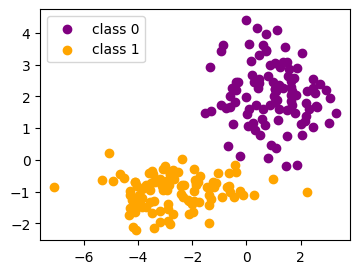

In [7]:
mu_1 = np.tile(np.array([1.0, 2.0]), 100)
scale_1 = np.tile(np.array([1.0, 1.0]), 100)
mu_2 = np.tile(np.array([-3.0, -1.0]), 100)
scale_2 = np.tile(np.array([1.5, 0.5]), 100)

points_1 = np.random.normal(mu_1, scale_1).reshape((-1, 2))
points_2 = np.random.normal(mu_2, scale_2).reshape((-1, 2))
X = np.vstack((points_1, points_2))
Y = np.concatenate((np.zeros(100), np.ones(100)))

fig, ax = plt.subplots(figsize=(4,3))
ax.scatter(x=X[:,0], y=X[:,1], alpha=0)  # just for auto-tune x_lim and y_lim
ax.scatter(x=points_1[:,0], y=points_1[:,1], c='purple', label='class 0')
ax.scatter(x=points_2[:,0], y=points_2[:,1], c='orange', label='class 1')
ax.legend()
plt.show()

We'll try to build the model that recognize from which distribution a sample comes. Again, we'll repeat learning 3 times.

In [8]:
loss_fun = MeansSquareLoss()

# Set number of epochs and learning rate
n_epochs = 200
lr = 0.5

models = []

for _ in range(3):
    clf = LayersSequence([
        LinearLayer(n_inputs=2, n_outputs=1),
        SigmoidActivation()
    ])
    for epoch in range(n_epochs):
        # forward step
        Y_pred = clf.forward(X)
        # calculate loss derivative at each input
        loss_derivative = loss_fun.differentiate(Y_pred=Y_pred, Y_true=Y.reshape(-1, 1))
        # backward step (gradient is saved in perceptron object)
        clf.backward(loss_derivative)
        # update step (gradient descent)
        clf.update(lr=lr)
    models.append(clf)

In [9]:
models

We'll show our points against the network's predictions filled counterplot.

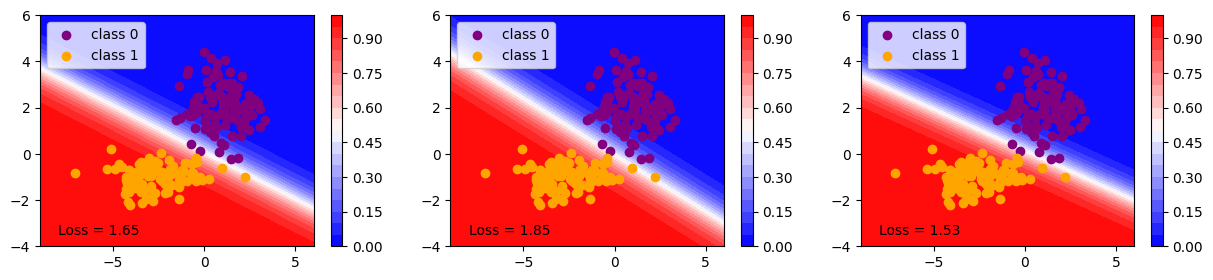

In [10]:
delta = 0.025
x = np.arange(-9.0, 6.01, delta)
y = np.arange(-4.0, 6.01, delta)
X_cords, Y_cords = np.meshgrid(x, y)
cords = np.hstack((X_cords.reshape(-1,1), Y_cords.reshape(-1,1)))

fig, axes = plt.subplots(1, 3, figsize=(15,3))
for ax, model in zip(axes, models):
    Z = model.forward(cords).reshape(X_cords.shape)
    loss = loss_fun(Y_pred=model.forward(X), Y_true=Y.reshape(-1,1))
    contourf_plot = ax.contourf(X_cords, Y_cords, Z, 20, cmap='bwr')
    ax.scatter(x=X[:,0], y=X[:,1], alpha=0)  # just for auto-tune x_lim and y_lim
    ax.scatter(x=points_1[:,0], y=points_1[:,1], c='purple', label='class 0')
    ax.scatter(x=points_2[:,0], y=points_2[:,1], c='orange', label='class 1')
    ax.legend()
    fig.colorbar(contourf_plot, ax=ax, location='right')
    ax.text(-8.0, -3.5, f'Loss = {loss:.2f}')
plt.show()

Now we'll repeat the experiment, this time using categorical entropy loss function. In order to use this, we have to change
some properties of the model - it will return two outputs, each corresponding to one class. On visualization, we show argmax.

In [11]:
loss_fun = CrossEntropyLoss()

# Set number of epochs and learning rate
n_epochs = 200
lr = 0.5

models = []

for _ in range(3):
    clf = LayersSequence([
        LinearLayer(n_inputs=2, n_outputs=2),
        SigmoidActivation()
    ])
    for epoch in range(n_epochs):
        # forward step
        Y_pred = clf.forward(X)
        # calculate loss derivative at each input
        loss_derivative = loss_fun.differentiate(Y_pred=Y_pred, Y_true=Y)
        # backward step (gradient is saved in perceptron object)
        clf.backward(loss_derivative)
        # update step (gradient descent)
        clf.update(lr=lr)
    models.append(clf)

In [12]:
models

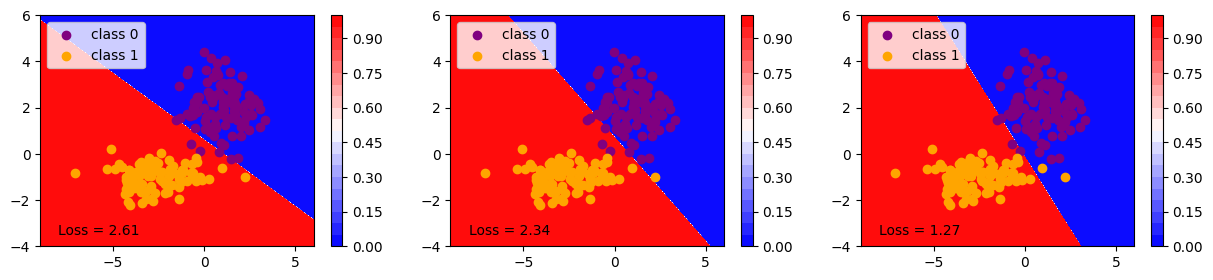

In [13]:
delta = 0.025
x = np.arange(-9.0, 6.01, delta)
y = np.arange(-4.0, 6.01, delta)
X_cords, Y_cords = np.meshgrid(x, y)
cords = np.hstack((X_cords.reshape(-1,1), Y_cords.reshape(-1,1)))

fig, axes = plt.subplots(1, 3, figsize=(15,3))
for ax, model in zip(axes, models):
    Z = np.argmax(model.forward(cords), axis=1).reshape(X_cords.shape)
    loss = loss_fun(Y_pred=model.forward(X), Y_true=Y)
    contourf_plot = ax.contourf(X_cords, Y_cords, Z, 20, cmap='bwr')
    ax.scatter(x=X[:,0], y=X[:,1], alpha=0)  # just for auto-tune x_lim and y_lim
    ax.scatter(x=points_1[:,0], y=points_1[:,1], c='purple', label='class 0')
    ax.scatter(x=points_2[:,0], y=points_2[:,1], c='orange', label='class 1')
    ax.legend()
    fig.colorbar(contourf_plot, ax=ax, location='right')
    ax.text(-8.0, -3.5, f'Loss = {loss:.2f}')
plt.show()

### Classification benchmark - Iris

We'll test our neural network code - we'll try to predict the species of flower. We'll use the well known _Iris_ dataset.

First of all, let's load data.

In [14]:
# load data from csv file in the `data` directory
iris_data = np.loadtxt('../data/iris/iris.data', delimiter=',', dtype=str)
# get class column, classes encoded with integers
classes = np.unique(iris_data[:, -1])
Y_one_hot = np.equal.outer(iris_data[:, -1], classes).astype('int')
Y = np.argmax(Y_one_hot, axis=-1)
# get features as floats
X = iris_data[:, :-1].astype('float')

In [15]:
Y[:5]

array([0, 0, 0, 0, 0], dtype=int64)

In [16]:
X[:5]

array([[5.1, 3.5, 1.4, 0.2],
       [4.9, 3. , 1.4, 0.2],
       [4.7, 3.2, 1.3, 0.2],
       [4.6, 3.1, 1.5, 0.2],
       [5. , 3.6, 1.4, 0.2]])

Let's divide our dataset into training and test parts.

In [17]:
test_fraction = 0.25
n_samples = X.shape[0]
n_training = int(n_samples * (1 - test_fraction))

indexes = np.arange(n_samples)
np.random.shuffle(indexes)

X_train, Y_train = X[indexes[:n_training]], Y[indexes[:n_training]]
X_test, Y_test = X[indexes[n_training:]], Y[indexes[n_training:]]
X_test.shape, Y_test.shape

((38, 4), (38,))

Now, we'll built the MLP neural network to predict classes probabilities. The architecture is as follows:

4 inputs -> 6 neurons (ReLU activation) -> 6 neurons (ReLU activation) -> 3 neurons (softmax activation)

In [18]:
clf = LayersSequence([
    LinearLayer(n_inputs=4, n_outputs=6),
    SigmoidActivation(),
    LinearLayer(n_inputs=6, n_outputs=6),
    SigmoidActivation(),
    LinearLayer(n_inputs=6, n_outputs=3),
    SoftmaxActivation()
])

Train the network on the training part of the dataset and plot the loss value in subsequent epochs.

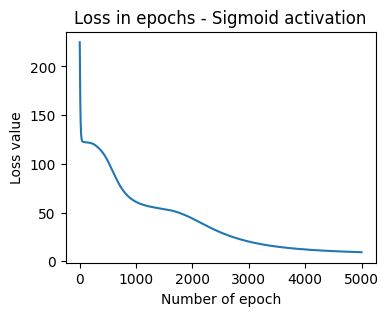

In [19]:
n_epochs = 5000
lr = 0.05

loss_fun = CrossEntropyLoss()

losses = np.zeros(n_epochs)
for i in range(n_epochs):
    Y_pred = clf.forward(X_train)
    loss_derivative = loss_fun.differentiate(Y_pred=Y_pred, Y_true=Y_train)
    clf.backward(loss_derivative)
    clf.update(lr=lr)
    losses[i] = loss_fun(Y_pred=clf.forward(X_train), Y_true=Y_train)

fig, ax = plt.subplots(figsize=(4,3))
ax.plot(np.arange(n_epochs)+1, losses)
ax.set_title("Loss in epochs - Sigmoid activation")
ax.set_xlabel("Number of epoch")
ax.set_ylabel("Loss value")
plt.show()

Test the network - predict on training and test subsets and calculate accuracies.

In [20]:
Y_pred_train = clf.forward(X_train).argmax(axis=-1)
Y_pred_test = clf.forward(X_test).argmax(axis=-1)

train_acc = np.sum(Y_pred_train == Y_train) / n_training * 100
test_acc = np.sum(Y_pred_test == Y_test) / (n_samples - n_training) * 100

print(f"Accuracy on training set: {train_acc:.2f} %")
print(f"Accuracy on test set: {test_acc:.2f} %")

Accuracy on training set: 99.11 %
Accuracy on test set: 97.37 %


Visualize the trained network's weights and biases, and it's activations for respective _Iris_ classes.

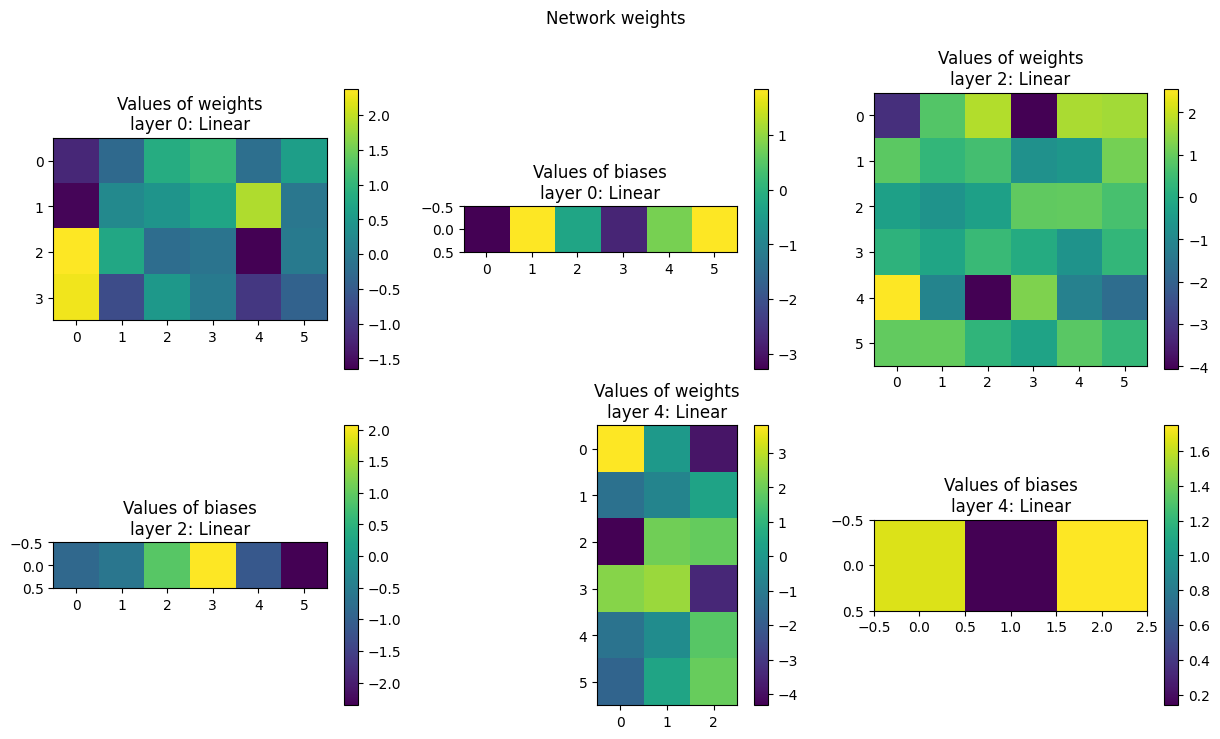

In [21]:
visualize_weights(
    network=clf,
    ncols=3,
    inds_to_visualize=[0,0,2,2,4,4],
    params_to_visualize=['weights', 'biases']*3
)

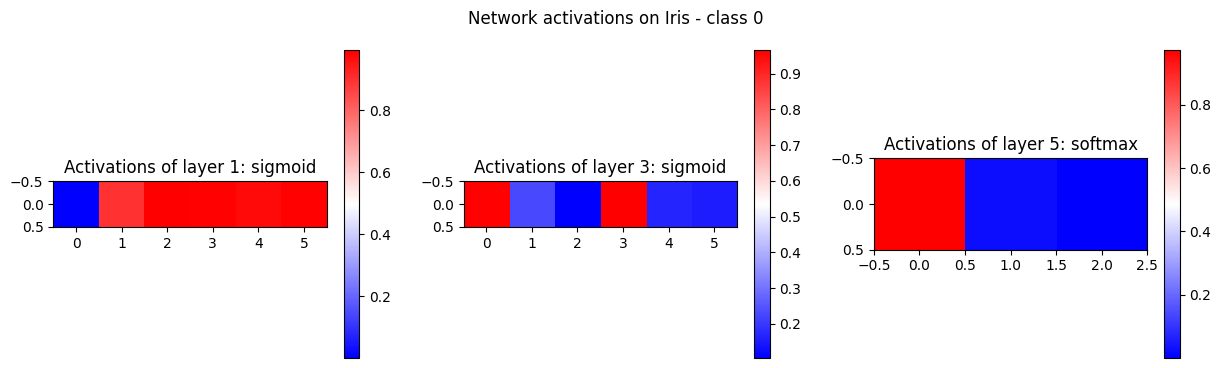

In [22]:
visualize_activations(
    network=clf,
    inds_to_visualize=[1,3,5],
    X=X_train[Y_train==0, :],
    title="Network activations on Iris - class 0"
)

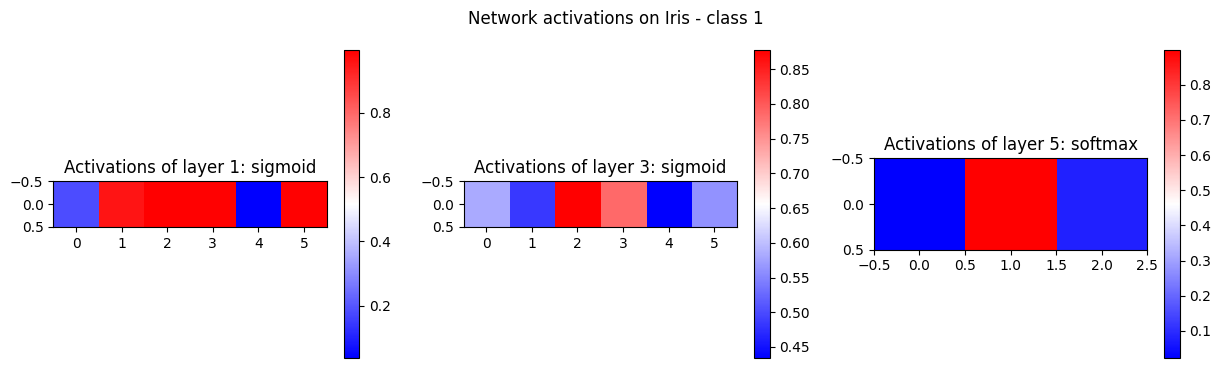

In [23]:
visualize_activations(
    network=clf,
    inds_to_visualize=[1,3,5],
    X=X_train[Y_train==1, :],
    title="Network activations on Iris - class 1"
)

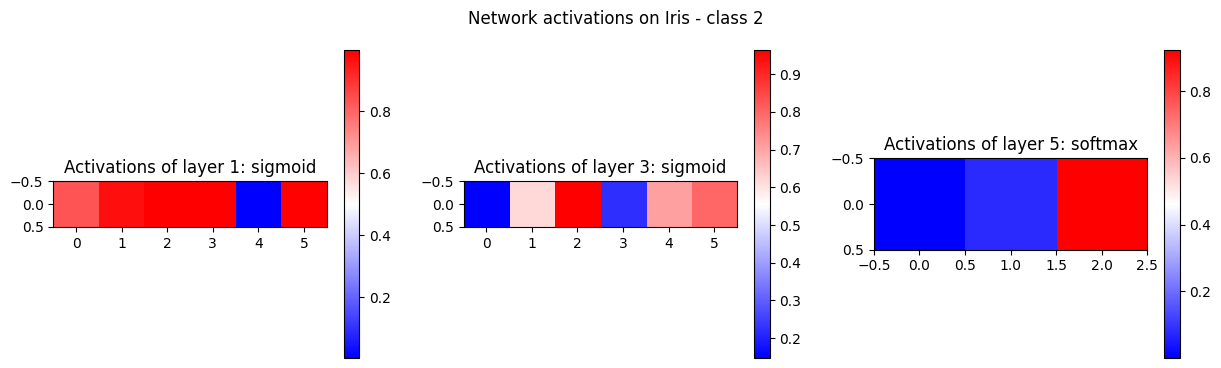

In [24]:
visualize_activations(
    network=clf,
    inds_to_visualize=[1,3,5],
    X=X_train[Y_train==2, :],
    title="Network activations on Iris - class 2"
)

Now we'll repeat the experiment, but with Sigmoid activation replaced with ReLU.

In [25]:
clf = LayersSequence([
    LinearLayer(n_inputs=4, n_outputs=6),
    ReLUActivation(),
    LinearLayer(n_inputs=6, n_outputs=6),
    ReLUActivation(),
    LinearLayer(n_inputs=6, n_outputs=3),
    SoftmaxActivation()
])

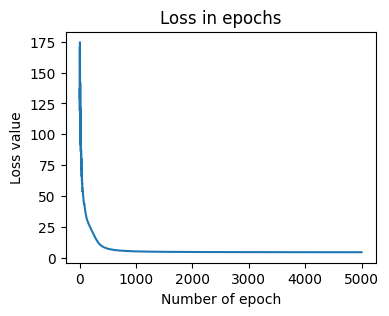

In [26]:
n_epochs = 5000
lr = 0.05

loss_fun = CrossEntropyLoss()

losses = np.zeros(n_epochs)
for i in range(n_epochs):
    Y_pred = clf.forward(X_train)
    loss_derivative = loss_fun.differentiate(Y_pred=Y_pred, Y_true=Y_train)
    clf.backward(loss_derivative)
    clf.update(lr=lr)
    losses[i] = loss_fun(Y_pred=clf.forward(X_train), Y_true=Y_train)

fig, ax = plt.subplots(figsize=(4,3))
ax.plot(np.arange(n_epochs)+1, losses)
ax.set_title("Loss in epochs")
ax.set_xlabel("Number of epoch")
ax.set_ylabel("Loss value")
plt.show()

In [27]:
Y_pred_train = clf.forward(X_train).argmax(axis=-1)
Y_pred_test = clf.forward(X_test).argmax(axis=-1)

train_acc = np.sum(Y_pred_train == Y_train) / n_training * 100
test_acc = np.sum(Y_pred_test == Y_test) / (n_samples - n_training) * 100

print(f"Accuracy on training set: {train_acc:.2f} %")
print(f"Accuracy on test set: {test_acc:.2f} %")

Accuracy on training set: 98.21 %
Accuracy on test set: 100.00 %


### Map of _Iris_ - autoencoder

We'll show the _Iris_ data on 2D space. In order to do so, we'll train the autoencoder on this data.
The central layer of the autoencoder network will have 2 neurons, so it'll be able to map original 4D data to 2D space.

The detailed architecture is as follows:

Encoder:

4 inputs -> 3 neurons (sigmoid activation) -> 2 neurons (no activation)

Decoder:

2 inputs -> 3 neurons(sigmoid activation) -> 4 neurons (no activation)

In [28]:
encoder = LayersSequence([
    LinearLayer(n_inputs=4, n_outputs=3),
    SigmoidActivation(),
    LinearLayer(n_inputs=3, n_outputs=2),
])

decoder = LayersSequence([
    LinearLayer(n_inputs=2, n_outputs=3),
    SigmoidActivation(),
    LinearLayer(n_inputs=3, n_outputs=4),
])

autoencoder = LayersSequence([
    encoder, decoder
])

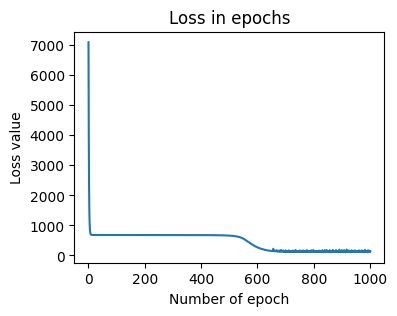

In [29]:
n_epochs = 1000
lr = 0.05

loss_fun = MeansSquareLoss()

losses = np.zeros(n_epochs)
for i in range(n_epochs):
    Y_pred = autoencoder.forward(X)
    loss_derivative = loss_fun.differentiate(Y_pred=Y_pred, Y_true=X)
    autoencoder.backward(loss_derivative)
    autoencoder.update(lr=lr)
    losses[i] = loss_fun(Y_pred=autoencoder.forward(X), Y_true=X)

fig, ax = plt.subplots(figsize=(4,3))
ax.plot(np.arange(n_epochs)+1, losses)
ax.set_title("Loss in epochs")
ax.set_xlabel("Number of epoch")
ax.set_ylabel("Loss value")
plt.show()

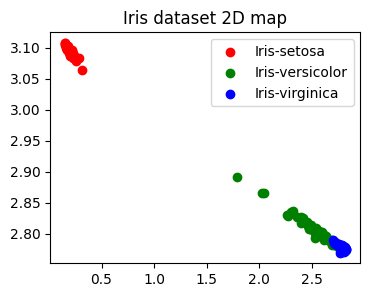

In [30]:
X_encoded = encoder.forward(X)

fig, ax = plt.subplots(figsize=(4,3))
ax.set_title("Iris dataset 2D map")
# draw all data invisible - so that axis lims are set properly
ax.scatter(x=X_encoded[:,0], y=X_encoded[:,1], alpha=0)
# draw encoding for each class
for cl_label, color in zip([0,1,2], ['r','g','b']):
    ax.scatter(
        x=X_encoded[Y==cl_label, 0],
        y=X_encoded[Y==cl_label, 1],
        c=color,
        label=classes[cl_label]
    )
# set legend
ax.legend()

plt.show()